# Fatal bicycle-car accidents, 2017

The [National Highway Traffic Safety Administration](https://www.nhtsa.gov/) (NHTSA) compiles annual data concerning a wide range of highway transportation issues.  One such database is the [Fatality Analysis Reporting System](https://www-fars.nhtsa.dot.gov/QueryTool/QuerySection/SelectYear.aspx) (FARS). We will dive into a subset of the 2017 FARS data to explore common causes of fatal bicycle-car interactions and then propose a potential solution, experimental design to test our solution, and some key success indicators.  

In [129]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
%matplotlib inline

In [2]:
bikes = pd.read_csv('2017_US_Bicycle_Fatalities.csv')

bikes.head()

,statenum,casenum,vnumber,pnumber,atmcond2,county,accday,acchr,accmon,caseyear,dayofweek,holiday,numfatal,speeding,bikedirection,bikeposition,crashlocation,crashtype
0,1,27,0,1,0,83,12,20,1,2017,5,0,1,0,1,1,3,231
1,1,359,0,1,0,121,16,21,6,2017,6,0,1,0,1,1,3,231
2,1,365,0,1,0,97,18,21,6,2017,1,0,1,0,1,1,3,129
3,1,448,0,1,0,83,6,8,8,2017,1,0,1,0,1,1,3,231
4,1,485,0,1,0,73,11,22,7,2017,3,0,1,0,1,1,3,255


In [58]:
bikes.dtypes

statenum          int64
casenum           int64
vnumber           int64
pnumber           int64
atmcond2          int64
county            int64
accday            int64
acchr             int64
accmon            int64
caseyear          int64
dayofweek         int64
holiday          object
numfatal          int64
speeding          int64
bikedirection     int64
bikeposition      int64
crashlocation     int64
crashtype         int64
dtype: object

In [3]:
bikes.describe()

,statenum,casenum,vnumber,pnumber,atmcond2,county,accday,acchr,accmon,caseyear,dayofweek,numfatal,speeding,bikedirection,bikeposition,crashlocation,crashtype
count,807.000000,807.000000,807.0,807.000000,807.000000,807.000000,807.000000,807.000000,807.000000,807.0,807.000000,807.000000,807.000000,807.000000,807.000000,807.000000,807.000000
mean,23.944238,942.060719,0.0,1.029740,0.022305,85.515489,16.090458,14.525403,6.781908,2017.0,4.091698,1.008674,0.084263,2.043371,1.452292,2.415118,274.266419
std,15.932180,906.339277,0.0,0.203219,0.378712,100.849663,8.763532,10.743526,3.250046,0.0,1.961545,0.092788,0.277954,2.253060,1.270935,1.079895,197.151161
min,1.000000,2.000000,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,2017.0,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,111.000000
25%,12.000000,285.000000,0.0,1.000000,0.000000,29.000000,8.000000,8.000000,4.000000,2017.0,2.000000,1.000000,0.000000,1.000000,1.000000,1.000000,212.000000
50%,21.000000,599.000000,0.0,1.000000,0.000000,63.000000,17.000000,15.000000,7.000000,2017.0,4.000000,1.000000,0.000000,1.000000,1.000000,3.000000,231.000000
75%,37.000000,1371.000000,0.0,1.000000,0.000000,103.000000,23.000000,19.000000,9.000000,2017.0,6.000000,1.000000,0.000000,2.000000,1.000000,3.000000,250.000000
max,55.000000,3393.000000,0.0,4.000000,10.000000,810.000000,31.000000,99.000000,12.000000,2017.0,7.000000,2.000000,1.000000,9.000000,9.000000,9.000000,980.000000


Lots of data here, but all of it is coded.  The date-related columns (accday, acchr, accmon, dayofweek) are all easy to parse by intuition, however, the rest need to be decoded via the FARS metadata tables.  I will occasionally explicitly decode some of the data in this EDA, where neccessary.  Other times I will only make comments to what the codes mean, and give a general sense of the major common accident themes.

In [4]:
# Break out number of fatal accidents by sub-group.
state = bikes.groupby('statenum')['numfatal'].sum().reset_index(drop=False)
month = bikes.groupby('accmon')['numfatal'].sum().reset_index(drop=False)
hour = bikes.groupby('acchr')['numfatal'].sum().reset_index(drop=False)
day_of_week = bikes.groupby('dayofweek')['numfatal'].sum().reset_index(drop=False)

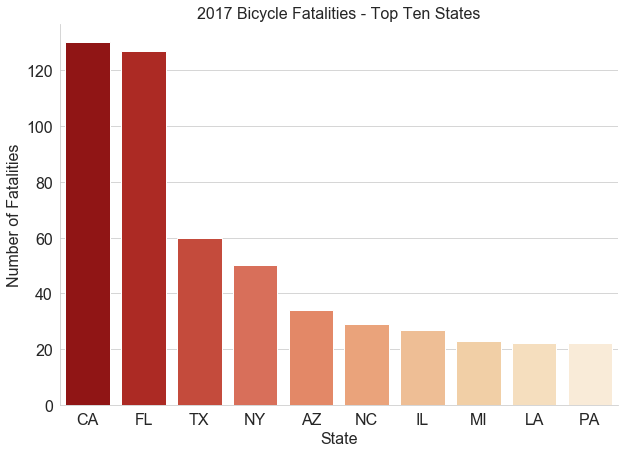

In [5]:
# Plot top ten states by number of fatalities.
top_ten_states = state.nlargest(10, 'numfatal')
top_ten_states['state'] = ['CA', 'FL', 'TX', 'NY', 'AZ', 
                           'NC', 'IL', 'MI', 'LA', 'PA']
tts_list = list(top_ten_states.state.values)

sns.set_style('whitegrid')

plt.figure(figsize=(10,7))
sns.barplot(x='state', y='numfatal', data=top_ten_states, 
            order=tts_list, palette='OrRd_r', ci=False)
plt.title('2017 Bicycle Fatalities - Top Ten States', size=16)
plt.xlabel('State', size=16)
plt.ylabel('Number of Fatalities', size=16)
plt.xticks(size=16)
plt.yticks(size=16)
sns.despine()
plt.show()


California and Florida had significantly more bicylists die than the other states. The nice weather probably plays a role here. I would guess that these states have higher biker rates than the others.  

In [82]:
bikes['date'] = pd.to_datetime({'year':2017, 
                                'month':bikes['accmon'], 
                                'day':bikes['accday']})

In [201]:
# Creating date DF and cumulative fatalities for the year
date_df = pd.DataFrame(bikes.loc[:,['date', 'numfatal']]).sort_values('date').reset_index(drop=True)
    
# Grouping all fatal accidents by date
groupdate_df = date_df.groupby('date')['numfatal'].sum()

# Filling in missing dates
groupdate_df = pd.DataFrame(groupdate_df.asfreq(freq='1D', fill_value=0)).reset_index(drop=False)

groupdate_df['cum_fatal'] = groupdate_df['numfatal'].cumsum()

# Rolling 7 day sum of fatalities
groupdate_df['14day_fatal'] = groupdate_df['numfatal'].rolling(14).sum()

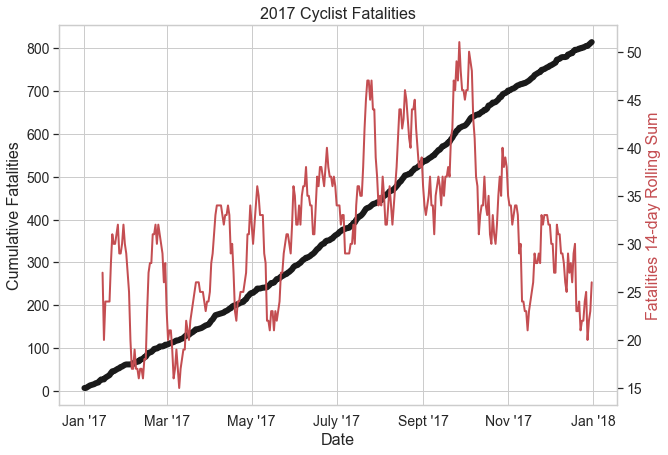

In [202]:
date_labels = ["Jan '17", "Mar '17", "May '17", "July '17", "Sept '17", "Nov '17", "Jan '18"]
ax1_ylabels = [x for x in range(-100,801,100)]
ax2_ylabels = [x for x in range(10,51,5)]


fig, ax1 = plt.subplots(figsize=(10,7))

ax2 = ax1.twinx()
ax1.plot(groupdate_df['date'], groupdate_df['cum_fatal'], linewidth=6, color='k')
ax2.plot(groupdate_df['date'], groupdate_df['14day_fatal'], linewidth=2, color='r')
plt.title('2017 Cyclist Fatalities', size=16)
ax1.set_xlabel('Date', size=16)
ax1.set_ylabel('Cumulative Fatalities', size=16)
ax2.set_ylabel('Fatalities 14-day Rolling Sum', color='r', size=16)
ax2.grid(False)
ax1.set_xticklabels(labels=date_labels, size=14)
ax1.set_yticklabels(labels=ax1_ylabels, size=14)
ax2.set_yticklabels(labels=ax2_ylabels, size=14)
plt.show()


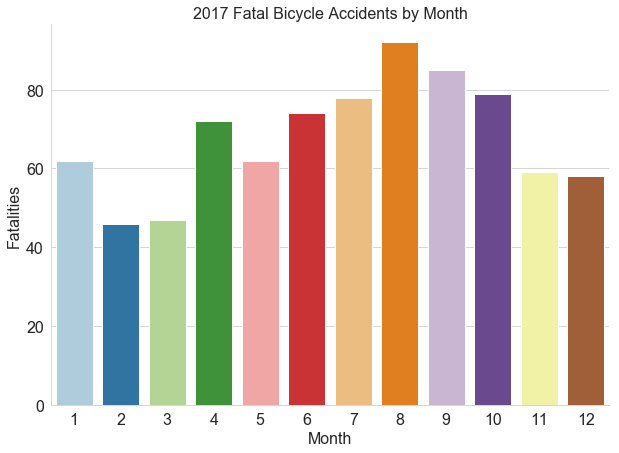

In [6]:
# Deaths by month.
plt.figure(figsize=(10,7))
sns.barplot(x='accmon', y='numfatal', 
            data=month, palette='Paired')
plt.title('2017 Fatal Bicycle Accidents by Month', size=16)
plt.ylabel('Fatalities', size=16)
plt.xlabel('Month', size=16)
plt.xticks(size=16)
plt.yticks(size=16)
sns.despine()
plt.show()

The deaths by month trend most certainly highlights a weather/cycling-rate dynamic.  More people bike in the summer and early fall than they do in winter.

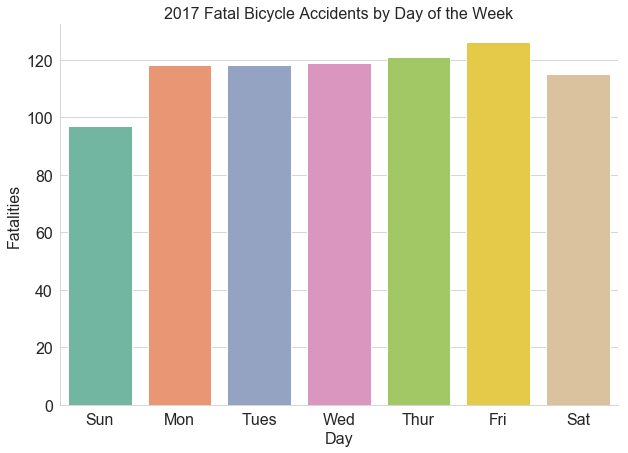

In [7]:
# Fatalities by day of the week.
day_of_week['day'] = ['Sun', 'Mon', 'Tues', 'Wed', 
                    'Thur', 'Fri', 'Sat']

plt.figure(figsize=(10,7))
sns.barplot(x='day', y='numfatal', 
            data=day_of_week, palette='Set2')
plt.title('2017 Fatal Bicycle Accidents by Day of the Week', size=16)
plt.ylabel('Fatalities', size=16)
plt.xlabel('Day', size=16)
plt.xticks(size=16)
plt.yticks(size=16)
sns.despine()
plt.show()

Interestingly, less cyclists are killed on the weekends than during the week.  This suggests that commuters may be be the largest demographic of cyclists killed.

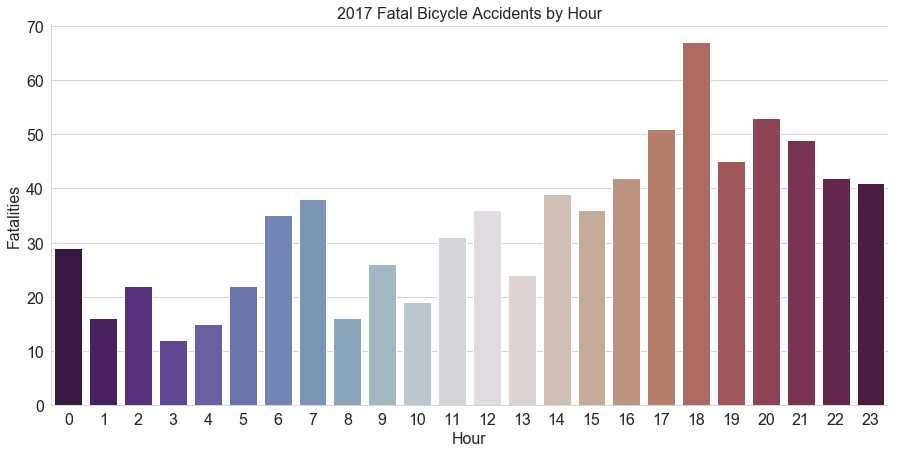

In [8]:
# Plot fatalities by hour.
plt.figure(figsize=(15,7))
sns.barplot(x='acchr', y='numfatal', data=hour, palette='twilight_shifted')
plt.title('2017 Fatal Bicycle Accidents by Hour', size=16)
plt.ylabel('Fatalities', size=16)
plt.xlabel('Hour', size=16)
plt.xlim(-0.5,23.5)
plt.xticks(size=16)
plt.yticks(size=16)
sns.despine()
plt.show()

Plotted by hour, we can definitely see two spikes corresponding with the morning and evening rush hours.  We also note that more of these accidents occur at night.  That morning commute spike seems unusually short though - morning rush hour, in my opinion, is from 6-9am.  Looks like that increase in cyclist fatalities corresponds specifically to the dark/dawn/'bright-sun-right-in-my-eyes' portion of the morning commute.  

In [9]:
count_heatmap = pd.pivot_table(bikes, 
                               values='numfatal',
                               index='accmon', 
                               columns='dayofweek', 
                               aggfunc=np.sum
                              ).sort_index(ascending=False)

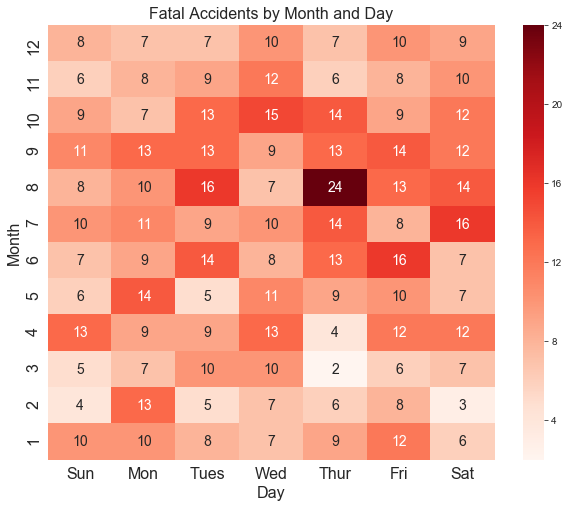

In [10]:
plt.figure(figsize=(10,8))
sns.heatmap(count_heatmap, 
            cmap='Reds', 
            annot=True, 
            annot_kws={'size':14}, 
            xticklabels=['Sun', 'Mon', 'Tues', 'Wed', 'Thur', 'Fri', 'Sat'])
plt.title('Fatal Accidents by Month and Day', size=16)
plt.xlabel('Day', size=16)
plt.ylabel('Month', size=16)
plt.xticks(size=16)
plt.yticks(size=16)
plt.show()

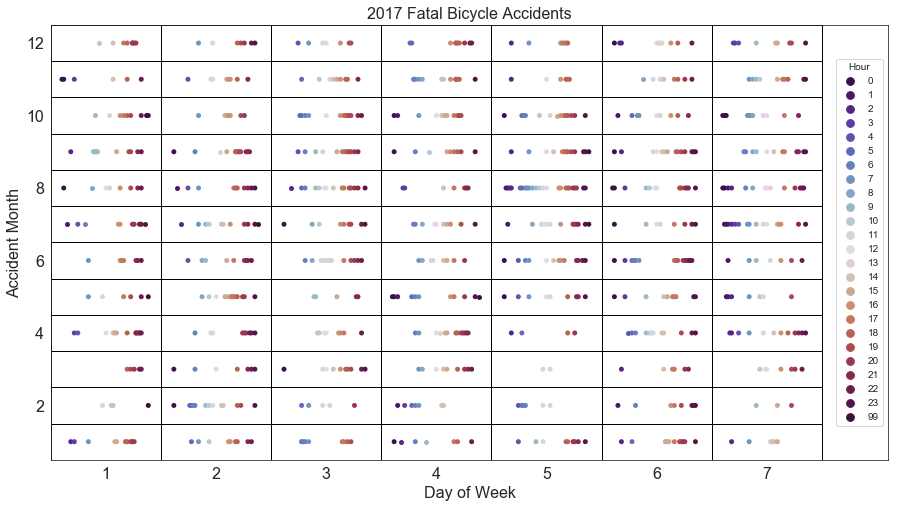

In [11]:
# Count of accidents for size control
count_mon_day = bikes.groupby(['accmon', 'dayofweek'])['numfatal'].sum()

# Lists for grid lines.
vert_lines = [x+0.5 for x in range(-1,13)]
hor_lines = [y+0.5 for y in range(-1,13)]

sns.set_style('white')

plt.figure(figsize=(15,8))
sns.swarmplot(x='dayofweek', y='accmon', hue='acchr', dodge=True,
              data=bikes, palette='twilight_shifted')
plt.title('2017 Fatal Bicycle Accidents', size=16)
plt.ylabel('Accident Month', size=16)
plt.xlabel('Day of Week', size=16)
plt.xlim(-0.5,7.1)
plt.ylim(0.5,12.5)
plt.xticks(size=16)
plt.yticks(size=16)
plt.legend(title='Hour', loc=5)
plt.vlines(vert_lines, 0, 13, linewidth=1, color='k')
plt.hlines(hor_lines, -1, 6.5, linewidth=1, color='k')
plt.show()

Here's a summary swarmplot which shows all fatal bike accidents in 2017.  As we've walked through above, you can see relatively few accidents in the winter with a dramatic increase in summer and fall. The commute times are the biggest contributors in the winter while the summer months have fatal accidents at all times of the day. The main time, year-round, for fatal accidents is the evening/night.

Now that we have a good feel for the temporal aspect of these accidents, let's look at some spatial context.  Where were the cyclists, which direction were they going, and some broader context.

In [32]:
bike_pos = bikes.groupby('bikeposition')['numfatal'
                                        ].sum().reset_index(drop=False
                                                           ).nlargest(3, 'numfatal')

bike_pos.loc[0, 'bikeposition'] = 'Travel lane'
bike_pos.loc[2, 'bikeposition'] = 'Side-/Cross-walk'
bike_pos.loc[1, 'bikeposition'] = 'Bike lane/Shoulder'

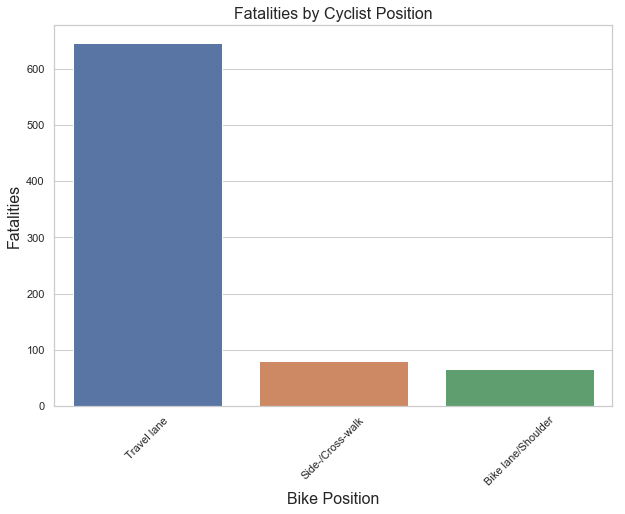

In [25]:
plt.figure(figsize=(10,7))
sns.set(style='whitegrid')
sns.barplot(x='bikeposition',
            y='numfatal', 
            data=bike_pos)
plt.title('Fatalities by Cyclist Position', size=16)
plt.xlabel('Bike Position', size=16)
plt.ylabel('Fatalities', size=16)
plt.xticks(rotation=45)
plt.show()

Most fatal accidents occur in a normal roadway with far fewer occurring in the more protected settings of sidewalks, crosswalks, and bike lanes.

In [33]:
bike_dir = bikes.groupby('bikedirection')['numfatal'
                                        ].sum().reset_index(drop=False)

bike_dir.loc[0, 'bikedirection'] = 'With Traffic'
bike_dir.loc[1, 'bikedirection'] = 'Facing Traffic'
bike_dir.loc[2, 'bikedirection'] = 'Not Applicable'
bike_dir.loc[3, 'bikedirection'] = 'Unknown'

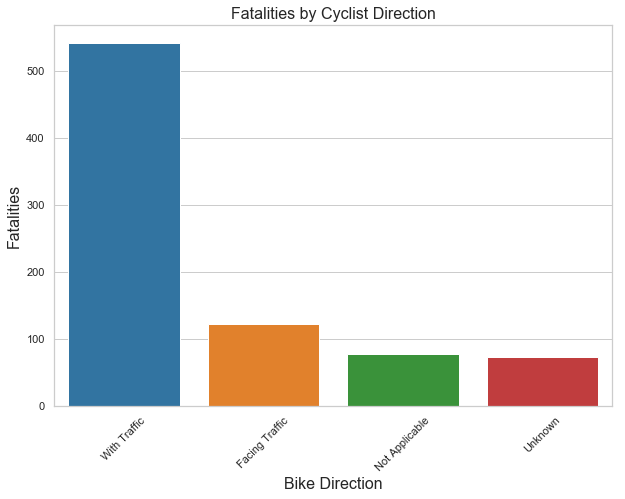

In [48]:
plt.figure(figsize=(10,7))
sns.barplot(x='bikedirection',
            y='numfatal', 
            data=bike_dir, 
            palette='tab10')
plt.title('Fatalities by Cyclist Direction', size=16)
plt.xlabel('Bike Direction', size=16)
plt.ylabel('Fatalities', size=16)
plt.xticks(rotation=45)
plt.show()

Bikers travelling with traffic - the correct direction to ride - were involved in 4 times more fatal accidents than those riding against traffic.

In [41]:
crash_loc = bikes.groupby('crashlocation'
                         )['numfatal'
                          ].sum().reset_index(drop=False
                                             ).sort_values('numfatal', ascending=False)[:3]

crash_loc.loc[2, 'crashlocation'] = 'Not in Intersection'
crash_loc.loc[0, 'crashlocation'] = 'At Intersection'
crash_loc.loc[1, 'crashlocation'] = 'Intersection-related'

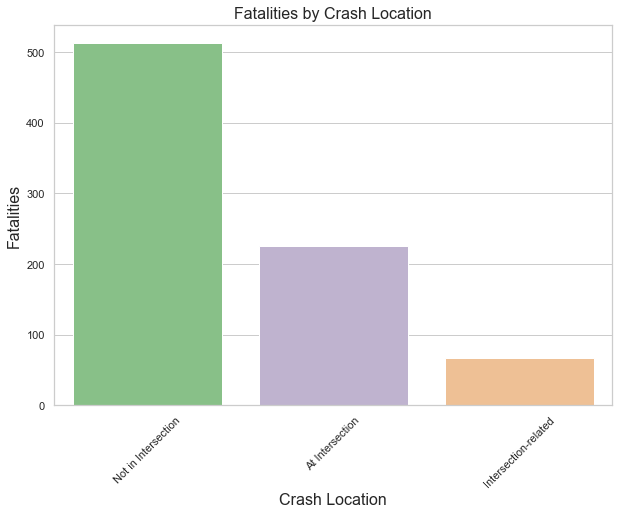

In [49]:
plt.figure(figsize=(10,7))
sns.barplot(x='crashlocation',
            y='numfatal', 
            data=crash_loc,
            palette='Accent')
plt.title('Fatalities by Crash Location', size=16)
plt.xlabel('Crash Location', size=16)
plt.ylabel('Fatalities', size=16)
plt.xticks(rotation=45)
plt.show()

Fatal accidents involving bikes happened primarily on a normal roadway while accidents at or related to an intersection occurred about half as often.

In [45]:
crash_type = bikes.groupby('crashtype'
                         )['numfatal'
                          ].sum().reset_index(drop=False
                                             ).sort_values('numfatal', ascending=False)[:5]

crash_type.loc[40, 'crashtype'] = 'Motorist Overtaking\n(Unknown/Other)'
crash_type.loc[37, 'crashtype'] = 'Motorist Overtaking\n(Undetected Bicyclist)'
crash_type.loc[32, 'crashtype'] = 'Bicyclist Left Turn\n(Same Direction)'
crash_type.loc[60, 'crashtype'] = 'Unknown Approach Paths'
crash_type.loc[38, 'crashtype'] = 'Motorist Overtaking\n(Misjudged Space)'

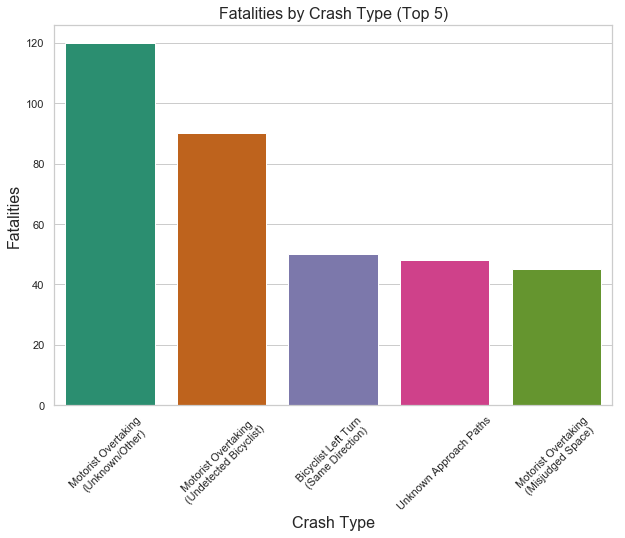

In [54]:
plt.figure(figsize=(10,7))
sns.barplot(x='crashtype',
            y='numfatal', 
            data=crash_type,
            palette='Dark2')
plt.title('Fatalities by Crash Type (Top 5)', size=16)
plt.xlabel('Crash Type', size=16)
plt.ylabel('Fatalities', size=16)
plt.xticks(rotation=45)
plt.show()

There are more than 80 different crash type categories in the database, but the top 5 types make up just about half of the total fatal accidents. From looking at these top 5 accident categories, we can see that the motorist is to blame a large percentage of the time.  


Additionally, we've previously seen that a lot of fatal accidents happen in poor lighting conditions.  **Fatal bicycle-car crashes appear to have two common themes.**
1. Cyclists are not visible enough to drivers to be identified and avoided properly.
2. Drivers are not mentally prepared to be sharing the road with cyclists in poor lighting conditions.

# Research Proposal

Cycling in the US is a [popular activity](https://www.statista.com/topics/1686/cycling/) and an [increasing means of transportation](https://www.census.gov/newsroom/press-releases/2014/cb14-86.html). Increasing physical activity (like cycling) has a [positive correlation](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2937005/) with lower obesity rates and has been used by all forms of [government and public policy groups](https://www.cdc.gov/obesity/downloads/pa_2011_web.pdf) as a way to fight against the ongoing obesity epidemic.  This makes it likely that cycling rates will continue to increase.  As more cyclists hit the road and increase the number of bike-car interactions occuring annually, it becomes increasingly likely that these interactions will lead to more cyclist fatalities. 

### Hypothesis
The creation of a two-pronged advertising campaign, funded jointly by the NHTSA and CDC, focused on driver awareness of cyclists and cyclist visibility will decrease fatal bike-vehicle accidents by highlighting two of the most common factors in fatal crashes.

### Experimental design
I propose an A/B test where the state of California recieves the advertising campaign and is compared to Florida, which is not subjected to the campaign. The key metric is cyclist fatalities attributed to a vehicular accident. I will compare monthly, year over year, and annual cumulative fatalities in California against Florida.

The initial roll-out in California will be the 6 months from March 2019 to August 2019.  If fatalities decrease 10%, year over year, in the absolute and also decrease relative to Florida's rates, then conclude that the advertising campagin is successful.  Continue the campaign nationally, if funds allow, or focus on the top biker fatality states in decreasing order until funds are completely allocated for the next 12 months.  